In [3]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

## Lecture des datas

In [4]:
df = pd.read_csv("all_data.csv", sep=";")
print(f"{len(df)} tickers")

1247 tickers


## Exclusions

### Tabac / Armes controversées

In [5]:
df2 = df.loc[(df['CWEAP_TIE']!=1) & (df['TOB_PRODUCER']!=1),:]
print(f"{len(df2)} tickers")

1237 tickers


Elimination de 10 entreprises

### Controverses 0/1

In [6]:
columns_controverse = ["E_CONTROVERSY", "S_CONTROVERSY", 'G_CONTROVERSY']

In [7]:
# Controverse E
for col in columns_controverse:
    print(f"NB {col} : {len(df.loc[df[col]<2,:])}")

NB E_CONTROVERSY : 28
NB S_CONTROVERSY : 149
NB G_CONTROVERSY : 35


In [8]:
df3 = df2.loc[~df[columns_controverse].lt(2).any(axis=1), :]
print(f"Elimination {len(df2)-len(df3)}")
print(f"Reste {len(df3)}")

Elimination 175
Reste 1062


### Note ESG < BB

In [9]:
print(f"NB : {len(df.loc[df["IVA_COMPANY_RATING"].isin(['B','CCC']),:])}")
df4 = df3.loc[~df["IVA_COMPANY_RATING"].isin(['B','CCC']),:]
print(f"Elimination {len(df3)-len(df4)}")
print(f"Reste {len(df4)}")

NB : 17
Elimination 11
Reste 1051


### Restrictions ODD

In [10]:
# odds = ["07","12","13"]
odds = [x for x in df.columns if x.startswith("SDG")]
for odd in odds:
    print(f"NB {odd} : {len(df.loc[df[odd]<=-2,:])}")

df5 = df4.loc[~df4[odds].le(-2).any(axis=1), :]
print(f"Elimination {len(df4)-len(df5)}")
print(f"Reste {len(df5)}")

NB SDG_01_NET_ALIGNMENT_SCORE : 28
NB SDG_02_NET_ALIGNMENT_SCORE : 7
NB SDG_03_NET_ALIGNMENT_SCORE : 48
NB SDG_04_NET_ALIGNMENT_SCORE : 16
NB SDG_05_NET_ALIGNMENT_SCORE : 1
NB SDG_06_NET_ALIGNMENT_SCORE : 14
NB SDG_07_NET_ALIGNMENT_SCORE : 83
NB SDG_08_NET_ALIGNMENT_SCORE : 6
NB SDG_09_NET_ALIGNMENT_SCORE : 37
NB SDG_10_NET_ALIGNMENT_SCORE : 9
NB SDG_11_NET_ALIGNMENT_SCORE : 51
NB SDG_12_NET_ALIGNMENT_SCORE : 106
NB SDG_13_NET_ALIGNMENT_SCORE : 83
NB SDG_14_NET_ALIGNMENT_SCORE : 64
NB SDG_15_NET_ALIGNMENT_SCORE : 66
NB SDG_16_NET_ALIGNMENT_SCORE : 28
NB SDG_17_NET_ALIGNMENT_SCORE : 70
Elimination 106
Reste 945


In [11]:
df5['EST_EU_TAXONOMY_MAX_REV'] = df5['EST_EU_TAXONOMY_MAX_REV'].fillna(0)
df5['Annualized return 10Y'] = df5['Annualized return 10Y'].fillna(0)
df5['Annualized return 10Y'] = df5['Annualized return 10Y'].fillna(0)
df5['INVEST_DURABLE'] = df5[['SDG_07_NET_ALIGNMENT_SCORE', 'SDG_12_NET_ALIGNMENT_SCORE', 'SDG_13_NET_ALIGNMENT_SCORE']].max(axis=1)

C:\Users\thibc\AppData\Local\Temp\ipykernel_12120\3610090802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['EST_EU_TAXONOMY_MAX_REV'] = df5['EST_EU_TAXONOMY_MAX_REV'].fillna(0)
C:\Users\thibc\AppData\Local\Temp\ipykernel_12120\3610090802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['Annualized return 10Y'] = df5['Annualized return 10Y'].fillna(0)
C:\Users\thibc\AppData\Local\Temp\ipykernel_12120\3610090802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [12]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# df6 = df5.loc[(df5['EST_EU_TAXONOMY_MAX_REV']>0) & (df5['ITR']>0),:] #Si Pas Taxo >0 trop de lignes => trop long a faire tourner

df6 = df5.loc[(df5['ITR']>0) & (df5['E_SCORE']>=3),:]
# Nombre de tickers
n = len(df6)
print(n)
perf_moy = df6['Annualized return 20Y'].values
taxonomie = df6['EST_EU_TAXONOMY_MAX_REV'].values
itr = df6['ITR'].values
durable = df6['INVEST_DURABLE']

secteurs_uniques = df6['gics_sector_name'].unique()  # Liste des secteurs uniques
m = len(secteurs_uniques)  # Nombre de secteurs

# Matrice binaire (1 si l'actif appartient au secteur, 0 sinon)
matrice_secteurs = np.array([[1 if df6.iloc[i]['gics_sector_name'] == secteur else 0 for secteur in secteurs_uniques] for i in range(n)])

# Fonction objectif (on minimise donc on prend -Perf_moy)
def objectif(w):
    return -np.dot(w, perf_moy)  # On minimise la valeur négative pour maximiser

# Contrainte : Taxonomie pondérée ≥ 10
def contrainte_taxonomie(w):
    return np.dot(w, taxonomie)-10.5

# Contrainte : ITR < 2
def contrainte_itr(w):
    return 1.95-np.dot(w, itr)

# Contrainte : Alignement environnemental pondéré ≥ 90%
def contrainte_alignement(w):
    filtres_durables = (durable >= 2).astype(int)  # 1 si durable > 2, sinon 0

    # Calcul de la somme des poids des entreprises ayant un score durable > 2
    return np.dot(w, filtres_durables) - 0.915  # Doit être ≥ 0

def contrainte_secteur(w):
    return 0.30 - np.dot(matrice_secteurs.T, w)  # Doit être ≥ 0 pour chaque secteur

# Contrainte : Somme des poids = 1
def contrainte_somme(w):
    return np.sum(w) - 1


# Définition des contraintes sous forme de dictionnaires
contraintes = [
    {'type': 'eq', 'fun': contrainte_somme},  # Somme des poids = 1
    {'type': 'ineq', 'fun': contrainte_taxonomie},  # Taxonomie pondérée ≥ 10
    {'type': 'ineq', 'fun': contrainte_itr},  # ITR < 2
    {'type': 'ineq', 'fun': contrainte_alignement}  # Investissement durable ≥ 90%
]

contraintes_secteurs = [{'type': 'ineq', 'fun': lambda w, j=j: contrainte_secteur(w)[j]} for j in range(m)]

contraintes = contraintes + contraintes_secteurs

# Bornes (chaque poids doit être positif et max 0.1)
bornes = [(0, 0.075) for _ in range(n)]

# Initialisation des poids (égalité répartie)
w0 = np.ones(n) / n

# Résolution avec SLSQP
resultat = minimize(objectif, w0, method='SLSQP', bounds=bornes, constraints=contraintes)

# Vérification des résultats
if resultat.success:
    w_opt = resultat.x
    df6['Poids'] = w_opt
else:
    print("L'optimisation a échoué :", resultat.message)

892


C:\Users\thibc\AppData\Local\Temp\ipykernel_12120\2311704661.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['Poids'] = w_opt


In [13]:
print(f"Return PTF : {(df6['Poids']*df6['Annualized return 20Y']).sum()}")
print(f"TAXO : {(df6['Poids']*df6['EST_EU_TAXONOMY_MAX_REV']).sum()}") 
print(f"ITR : {(df6['Poids']*df6['ITR']).sum()}") 
print(f"Poids : {(df6['Poids']).sum()}") 
filtres_durables = (df6['INVEST_DURABLE'] >= 2).astype(int)  # 1 si durable > 2, sinon 0.astype(int)  # 1 si durable > 2, sinon 0
print(f"Investissement durable : {(filtres_durables*df6['Poids']).sum()}") 

col_scores = ['E_SCORE', 'S_SCORE', 'G_SCORE']
for col in col_scores:
    print(f"{col} : {(df6[col]*df6['Poids']).sum()}") 

col_inten = ['INTENSITY_SCOPE_1', 'INTENSITY_SCOPE_2', 'INTENSITY_SCOPE_3']
for col in col_inten:
    print(f"{col} : {(df6[col]*df6['Poids']).sum()}") 

    
col_foot = ['FOOTPRINT_SCOPE_1', 'FOOTPRINT_SCOPE_2', 'FOOTPRINT_SCOPE_3']
for col in col_foot:
    print(f"{col} : {(df6[col]*df6['Poids']).sum()}")

for col in odds:
    print(f"{col} : {(df6[col]*df6['Poids']).sum()}")

Return PTF : 0.2952406322152831
TAXO : 10.499999999797872
ITR : 1.9500000000353634
Poids : 1.000000000000219
Investissement durable : 0.9150000000001192
E_SCORE : 7.152072174232554
S_SCORE : 6.0178757585207485
G_SCORE : 6.344478413943968
INTENSITY_SCOPE_1 : 4.598635080079926
INTENSITY_SCOPE_2 : 4.990116696028779
INTENSITY_SCOPE_3 : 244.8608789764395
FOOTPRINT_SCOPE_1 : 3.977009157335956
FOOTPRINT_SCOPE_2 : 3.0957208307484265
FOOTPRINT_SCOPE_3 : 169.42812374331345
SDG_01_NET_ALIGNMENT_SCORE : 0.8240090114326927
SDG_02_NET_ALIGNMENT_SCORE : -0.0749999999999396
SDG_03_NET_ALIGNMENT_SCORE : 0.46431495099851927
SDG_04_NET_ALIGNMENT_SCORE : 0.30274390244325866
SDG_05_NET_ALIGNMENT_SCORE : 2.312500000000453
SDG_06_NET_ALIGNMENT_SCORE : 0.5924359150090425
SDG_07_NET_ALIGNMENT_SCORE : 1.313944479739114
SDG_08_NET_ALIGNMENT_SCORE : 1.7129142524354193
SDG_09_NET_ALIGNMENT_SCORE : 0.949733299170507
SDG_10_NET_ALIGNMENT_SCORE : 1.8759889406996382
SDG_11_NET_ALIGNMENT_SCORE : 0.11250000000011386
SDG

In [14]:
print(f"Return PTF : {(df['Weight in MSCI World']*df['Annualized return 20Y']).sum()}")
print(f"TAXO : {(df['Weight in MSCI World']*df['EST_EU_TAXONOMY_MAX_REV']).sum()}") 
print(f"ITR : {(df['Weight in MSCI World']*df['ITR']).sum()}") 
print(f"Poids : {(df['Weight in MSCI World']).sum()}") 
df['INVEST_DURABLE'] = df[['SDG_07_NET_ALIGNMENT_SCORE', 'SDG_12_NET_ALIGNMENT_SCORE', 'SDG_13_NET_ALIGNMENT_SCORE']].max(axis=1)
filtres_durables = (df['INVEST_DURABLE'] >= 2).astype(int)  # 1 si durable > 2, sinon 0.astype(int)  # 1 si durable > 2, sinon 0
print(f"Investissement durable : {(filtres_durables*df['Weight in MSCI World']).sum()}") 

col_scores = ['E_SCORE', 'S_SCORE', 'G_SCORE']
for col in col_scores:
    print(f"{col} : {(df[col]*df['Weight in MSCI World']).sum()}") 

col_inten = ['INTENSITY_SCOPE_1', 'INTENSITY_SCOPE_2', 'INTENSITY_SCOPE_3']
for col in col_inten:
    print(f"{col} : {(df[col]*df['Weight in MSCI World']).sum()}") 

col_foot = ['FOOTPRINT_SCOPE_1', 'FOOTPRINT_SCOPE_2', 'FOOTPRINT_SCOPE_3']
for col in col_foot:
    print(f"{col} : {(df[col]*df['Weight in MSCI World']).sum()}")

for col in odds:
    print(f"{col} : {(df[col]*df['Weight in MSCI World']).sum()}")

Return PTF : 0.1589968660964774
TAXO : 8.88141198983
ITR : 2.3882738824
Poids : 0.999999286
Investissement durable : 0.556473561
E_SCORE : 6.702299149800001
S_SCORE : 5.1125413661
G_SCORE : 5.6482565943
INTENSITY_SCOPE_1 : 75.69229832018408
INTENSITY_SCOPE_2 : 19.946423978449946
INTENSITY_SCOPE_3 : 756.2246020384931
FOOTPRINT_SCOPE_1 : 118.00648809367438
FOOTPRINT_SCOPE_2 : 27.010985263301677
FOOTPRINT_SCOPE_3 : 1373.604056364562
SDG_01_NET_ALIGNMENT_SCORE : 0.0775825055
SDG_02_NET_ALIGNMENT_SCORE : 0.019335309000000002
SDG_03_NET_ALIGNMENT_SCORE : -0.111505415
SDG_04_NET_ALIGNMENT_SCORE : -0.022077644
SDG_05_NET_ALIGNMENT_SCORE : 1.9017966155000001
SDG_06_NET_ALIGNMENT_SCORE : 0.9266744179999999
SDG_07_NET_ALIGNMENT_SCORE : 0.6206072210000001
SDG_08_NET_ALIGNMENT_SCORE : 1.0800233255
SDG_09_NET_ALIGNMENT_SCORE : 0.100041403
SDG_10_NET_ALIGNMENT_SCORE : 1.0660665655
SDG_11_NET_ALIGNMENT_SCORE : -0.03663600200000001
SDG_12_NET_ALIGNMENT_SCORE : 1.034473784
SDG_13_NET_ALIGNMENT_SCORE : 0

In [15]:
# Repartition sectorielle
round((df6.groupby('gics_sector_name')['Poids'].sum())*100,2)

gics_sector_name
Communication Services     8.50
Consumer Discretionary    15.97
Consumer Staples           0.00
Energy                     0.00
Financials                 7.50
Health Care               23.03
Industrials                7.50
Information Technology    30.00
Materials                  0.00
Real Estate                7.50
Utilities                  0.00
Name: Poids, dtype: float64

In [16]:
# Sous secteur
df_sect = df6.groupby('industry_group')['Poids'].sum()
round(df_sect[df_sect>0.01]*100,2)

industry_group
Apparel                    7.50
Biotechnology              7.50
Commercial Services        7.50
Computers                  7.50
Diversified Finan Serv     7.50
Electronics                7.50
Healthcare-Products        4.40
Internet                   1.97
Media                      7.50
Pharmaceuticals            3.62
Real Estate                7.50
Retail                     7.50
Semiconductors             7.50
Software                  15.00
Name: Poids, dtype: float64

In [17]:
# Repartition geo
df_geo = df6.groupby('country')['Poids'].sum()
round(df_geo[df_geo>0.01]*100,2)

country
BRITAIN           7.50
DENMARK           3.62
FRANCE           11.90
GERMANY           7.50
SWEDEN            7.50
UNITED STATES    61.97
Name: Poids, dtype: float64

In [18]:
# Repartition geo
df_esg = df6.groupby('IVA_COMPANY_RATING')['Poids'].sum()
round(df_esg[df_esg>0.01]*100,2)

IVA_COMPANY_RATING
A       9.02
AA     37.50
AAA    25.57
BB      1.00
BBB    26.90
Name: Poids, dtype: float64

In [19]:
df6[df6['Poids']>0.001]

,ticker,name,isin,country,currency,gics_sector_name,industry_group,region_en,Weight in MSCI World,Annualized return 20Y,...,FOOTPRINT_SCOPE_1,FOOTPRINT_SCOPE_2,FOOTPRINT_SCOPE_3,INTENSITY_SCOPE_1,INTENSITY_SCOPE_2,INTENSITY_SCOPE_3,EV,SALES,INVEST_DURABLE,Poids
1,NVDA US Equity,NVIDIA Corp,US67066G1040,UNITED STATES,USD,Information Technology,Semiconductors,North America,0.046132,0.396705,...,0.018164,0.224788,34.721009,0.131528,1.627755,251.425343,3.359642e+06,109406.527100,6.5,0.075000
14,MA US Equity,Mastercard Inc,US57636Q1040,UNITED STATES,USD,Financials,Diversified Finan Serv,North America,0.006298,0.289978,...,0.033665,0.459141,24.730839,0.135197,1.843861,99.316304,4.479303e+05,26302.422900,2.0,0.075000
19,NFLX US Equity,Netflix Inc,US64110L1061,UNITED STATES,USD,Communication Services,Internet,North America,0.005515,0.376162,...,0.353979,0.415922,115.939906,0.711690,0.836228,233.102162,3.089634e+05,36237.703140,1.0,0.010000
22,CRM US Equity,Salesforce Inc,US79466L3024,UNITED STATES,USD,Information Technology,Software,North America,0.004466,0.256363,...,0.062587,4.381089,59.867483,0.111356,7.794915,106.517341,2.710248e+05,35920.855100,3.5,0.075000
24,NOVOB DC Equity,Novo Nordisk A/S,DK0062498333,DENMARK,DKK,Health Care,Pharmaceuticals,Europe,0.004264,0.218411,...,0.706436,0.135853,67.557619,2.149638,0.413392,205.573224,4.682249e+05,36285.180300,2.0,0.036233
33,NOW US Equity,ServiceNow Inc,US81762P1021,UNITED STATES,USD,Information Technology,Software,North America,0.003177,0.232904,...,0.058149,1.315634,23.429482,0.240423,5.439600,96.871189,1.772127e+05,10107.177600,3.0,0.069512
60,BKNG US Equity,Booking Holdings Inc,US09857L1089,UNITED STATES,USD,Consumer Discretionary,Internet,North America,0.002389,0.318621,...,0.115734,0.004953,653.075464,0.169991,0.007276,959.241130,1.386878e+05,22265.926800,2.0,0.009724
155,CMG US Equity,Chipotle Mexican Grill Inc,US1696561059,UNITED STATES,USD,Consumer Discretionary,Retail,North America,0.001189,0.284092,...,7.758674,8.242878,109.326461,13.711046,14.566726,193.200545,7.951385e+04,10610.277240,2.0,0.075000
173,REGN US Equity,Regeneron Pharmaceuticals Inc,US75886F1075,UNITED STATES,USD,Health Care,Biotechnology,North America,0.001099,0.254785,...,2.655695,2.026112,96.964499,5.203772,3.970119,189.999664,1.111384e+05,13374.913890,2.0,0.075000
232,FTNT US Equity,Fortinet Inc,US34959E1091,UNITED STATES,USD,Information Technology,Computers,North America,0.000869,0.259116,...,0.102035,0.416515,44.521282,0.240806,0.982984,105.071170,5.520495e+04,5516.061720,2.0,0.075000


In [29]:
print(df6.columns.tolist())

['ticker', 'name', 'isin', 'country', 'currency', 'gics_sector_name', 'industry_group', 'region_en', 'Weight in MSCI World', 'Annualized return 20Y', 'Annualized return 10Y', 'Annualized return 5Y', 'Annualized return 1Y', 'Volatility 20Y', 'Volatility 10Y', 'Volatility 5Y', 'Volatility 1Y', 'Sharpe 20Y', 'Sharpe 10Y', 'Sharpe 5Y', 'Sharpe 1Y', 'VaR 99% 20Y', 'VaR 99% 10Y', 'VaR 99% 5Y', 'VaR 99% 1Y', 'VaR 95% 20Y', 'VaR 95% 10Y', 'VaR 95% 5Y', 'VaR 95% 1Y', 'CVaR 95% 20Y', 'CVaR 95% 10Y', 'CVaR 95% 5Y', 'CVaR 95% 1Y', 'Max drawdown 20Y', 'Max drawdown 10Y', 'Max drawdown 5Y', 'Max drawdown 1Y', 'ROA', 'ROE', 'ROIC', 'Net margin', 'Gross margin', 'Dividend payout ratio', 'Dividend yield', 'FCF yield', 'Debt assets', 'Quick ratio', 'Current ratio', 'PE ratio', 'PB ratio', 'PS ratio', 'PCF ratio', 'ITR', 'S1_ITR', 'S2_ITR', 'S3_ITR', 'CBN_LCT_SCORE', 'IVA_COMPANY_RATING', 'E_SCORE', 'S_SCORE', 'G_SCORE', 'E_CONTROVERSY', 'S_CONTROVERSY', 'G_CONTROVERSY', 'SDG_01_NET_ALIGNMENT_SCORE', 'SD

C:\Users\thibc\AppData\Local\Temp\ipykernel_12120\2030503218.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thibc\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


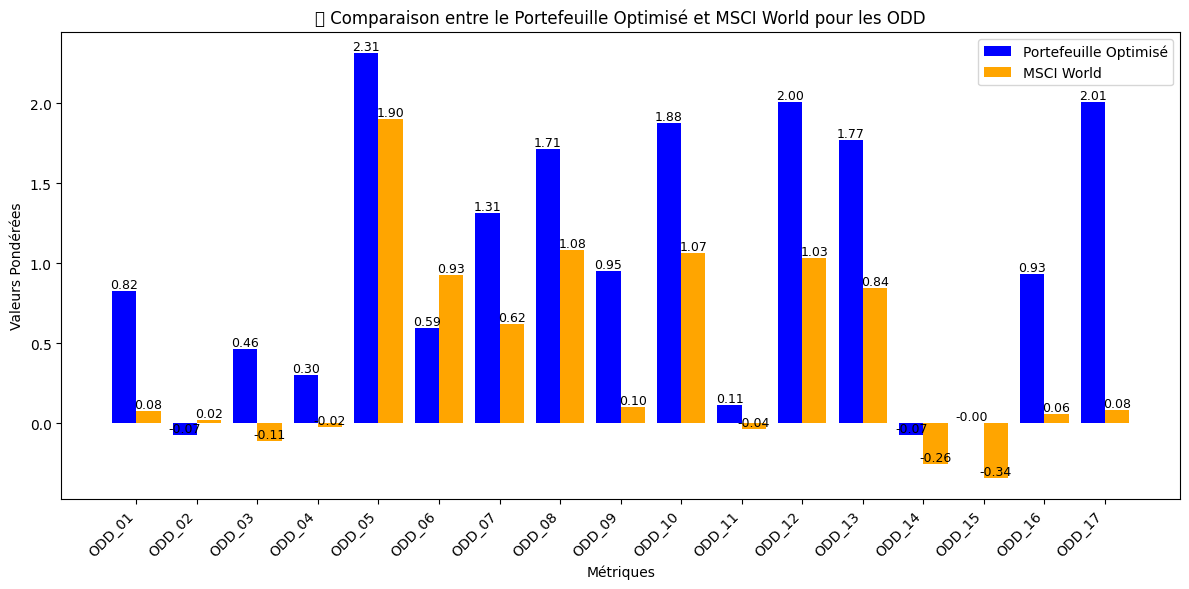

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 📌 Calcul des valeurs pour df6 (portefeuille optimisé)
df6_values = [
    (df6['Poids'] * df6[metric]).sum() if metric in df6.columns else None for metric in odds
]

# 📌 Calcul des valeurs pour df (MSCI World)
df_values = [
    (df['Weight in MSCI World'] * df[metric]).sum() if metric in df.columns else None for metric in odds
]

# 📌 Création du graphique
x = np.arange(len(odds))  # Indices des barres
width = 0.4  # Largeur des barres

fig, ax = plt.subplots(figsize=(12, 6))

# 🔹 Barres pour le portefeuille optimisé (df6)
bars1 = ax.bar(x - width/2, df6_values, width, label="Portefeuille Optimisé", color='blue')

# 🔹 Barres pour MSCI World (df)
bars2 = ax.bar(x + width/2, df_values, width, label="MSCI World", color='orange')

# 📌 Personnalisation du graphique
ax.set_xlabel("Métriques")
ax.set_ylabel("Valeurs Pondérées")
ax.set_title("📊 Comparaison entre le Portefeuille Optimisé et MSCI World pour les ODD")
ax.set_xticks(x)
ax.set_xticklabels(["ODD_"+x.split("_")[1] for x in odds], rotation=45, ha="right")
ax.legend()

# 📌 Ajouter les valeurs sur les barres
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha="center", va="bottom", fontsize=9)

# 📌 Affichage
plt.tight_layout()
plt.show()


In [27]:
import plotly.graph_objects as go
import numpy as np

# 📌 Calcul des valeurs pour df6 (portefeuille optimisé)
df6_values = [
    (df6['Poids'] * df6[metric]).sum() if metric in df6.columns else None for metric in odds
]

# 📌 Calcul des valeurs pour df (MSCI World)
df_values = [
    (df['Weight in MSCI World'] * df[metric]).sum() if metric in df.columns else None for metric in odds
]

# 📌 Création du graphique
x = np.arange(len(odds))  # Indices des barres

fig = go.Figure()

# 🔹 Barres pour le portefeuille optimisé (df6)
fig.add_trace(go.Bar(
    x=["ODD_" + x.split("_")[1] for x in odds],
    y=df6_values,
    name="Fonds article 9",
    marker_color='blue'
))

# 🔹 Barres pour MSCI World (df)
fig.add_trace(go.Bar(
    x=["ODD_" + x.split("_")[1] for x in odds],
    y=df_values,
    name="MSCI World",
    marker_color='orange'
))

# 📌 Personnalisation du graphique
fig.update_layout(
    title="Comparaison entre notre fonds article 9 et et MSCI World pour les ODD",
    xaxis_title="ODD",
    yaxis_title="Score moyen",
    barmode='group',
    template='plotly_white',  # Thème professionnel
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="black"
    ),
    legend=dict(
        title="Légende",
        x=0.02, y=0.98,
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='black',
        borderwidth=1
    )
)

# 📌 Affichage
fig.show()

In [33]:
scores = ['SCOPE_1', 'SCOPE_2', 'SCOPE_3', 'FOOTPRINT_SCOPE_1', 'FOOTPRINT_SCOPE_2', 'FOOTPRINT_SCOPE_3']

# 📌 Calcul des valeurs pour df6 (portefeuille optimisé)
df6_values = [
    (df6['Poids'] * df6[metric]).sum() if metric in df6.columns else None for metric in scores
]

# 📌 Calcul des valeurs pour df (MSCI World)
df_values = [
    (df['Weight in MSCI World'] * df[metric]).sum() if metric in df.columns else None for metric in scores
]

# 📌 Création du graphique
x = np.arange(len(scores))  # Indices des barres

fig = go.Figure()

# 🔹 Barres pour le portefeuille optimisé (df6)
fig.add_trace(go.Bar(
    x=[x for x in scores],
    y=df6_values,
    name="Fonds article 9",
    marker_color='blue'
))

# 🔹 Barres pour MSCI World (df)
fig.add_trace(go.Bar(
    x=[x for x in scores],
    y=df_values,
    name="MSCI World",
    marker_color='orange'
))

# 📌 Personnalisation du graphique
fig.update_layout(
    title="Comparaison entre notre fonds article 9 et et MSCI World pour les scores E,S & G et les scores de controverses",
    xaxis_title="Pilier",
    yaxis_title="Score moyen",
    barmode='group',
    template='plotly_white',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="black"
    ),
    legend=dict(
        title="Légende",
        x=0.02, y=0.98,
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='black',
        borderwidth=1
    )
)

# 📌 Affichage
fig.show()

In [ ]:
scores = ['SCOPE_1', 'SCOPE_2', 'SCOPE_3', 'FOOTPRINT_SCOPE_1', 'FOOTPRINT_SCOPE_2', 'FOOTPRINT_SCOPE_3']

# 📌 Calcul des valeurs pour df6 (portefeuille optimisé)
df6_values = [
    (df6['Poids'] * df6[metric]).sum() if metric in df6.columns else None for metric in scores
]

# 📌 Calcul des valeurs pour df (MSCI World)
df_values = [
    (df['Weight in MSCI World'] * df[metric]).sum() if metric in df.columns else None for metric in scores
]

# 📌 Création du graphique
x = np.arange(len(scores))  # Indices des barres

fig = go.Figure()

# 🔹 Barres pour le portefeuille optimisé (df6)
fig.add_trace(go.Bar(
    x=[x for x in scores],
    y=df6_values,
    name="Fonds article 9",
    marker_color='blue'
))

# 🔹 Barres pour MSCI World (df)
fig.add_trace(go.Bar(
    x=[x for x in scores],
    y=df_values,
    name="MSCI World",
    marker_color='orange'
))

# 📌 Personnalisation du graphique
fig.update_layout(
    title="Comparaison entre notre fonds article 9 et et MSCI World pour les scores Scopes 1 à 3",
    xaxis_title="Pilier",
    yaxis_title="Score moyen",
    barmode='group',
    template='plotly_white',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="black"
    ),
    legend=dict(
        title="Légende",
        x=0.02, y=0.98,
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='black',
        borderwidth=1
    )
)

# 📌 Affichage
fig.show()